# [Linear regression from scratch](http://gluon.mxnet.io/chapter02_supervised-learning/linear-regression-scratch.html)

Powerful ML libraries can eliminate repetitive work, but if you rely too much on abstractions, you might never learn how neural networks really work under the hood.  
So for this first example, let’s get our hands dirty and build everything from scratch, relying only on a`utograd` and `NDArray`.  
First, we’ll import the same dependencies as in the [autograd chapter](http://gluon.mxnet.io/chapter01_crashcourse/autograd.html).  
We’ll also import the powerful `gluon` package but in this chapter, we’ll only be using it for data loading.

In [1]:
# The kernel for this notebook is running Python 3, but we'll see:
from __future__ import print_function
import mxnet as mx
from mxnet import nd, autograd, gluon
mx.random.seed(1)

## Set the context

We’ll also want to specify the contexts where computation should happen.  
This tutorial is so simple that you could probably run it on a calculator watch.  
But, to develop good habits we’re going to specify two contexts: one for data and one for our models.

In [2]:
data_ctx = mx.cpu()
model_ctx = mx.cpu()

## Linear regression

To get our feet wet, we'll start off by looking at the problem of regression.  
This is the task of predicting a *real valued target* $y$ given a data point $x$.  
In linear regression, the simplest and still perhaps the most useful approach, we assume that prediction can be expressed as a *linear* combination of the input features (thus giving the name *linear* regression):  
$$\hat{y} = w_1 \cdot x_1 + ... + w_d \cdot x_d + b$$  
Given a collection of data points $X$, and corresponding target values $\boldsymbol{y}$ we'll try to find the *weight* vector $\boldsymbol{w}$ and bias term $b$ (also called an *offset* or *intercept*) that approximately associate data points $\boldsymbol{x}_i$ with their corresponding labels ``y_i``.  
Using slightly more advanced math notation, we can express the predictions $\boldsymbol{\hat{y}}$ corresponding to a collection of datapoints $X$ via the matrix-vector product:  
$$\boldsymbol{\hat{y}} = X \boldsymbol{w} + b$$  
Before we can get going, we will need two more things:  
* Some way to measure the quality of the current model  
* Some way to manipulate the model to improve its quality

### Square loss

In order to say whether we’ve done a good job, we need some way to measure the quality of a model.  
Generally, we will define a loss function that says how far are our predictions from the correct answers.  
For the classical case of linear regression, we usually focus on the squared error.  
Specifically, our loss will be the sum, over all examples, of the squared error $(y_i−\hat{y})^2)$ on each:  
$$\ell(y, \hat{y}) = \sum_{i=1}^n (\hat{y}_i-y_i)^2.$$  
For one-dimensional data, we can easily visualize the relationship between our single feature and the target variable. It’s also easy to visualize a linear predictor and it’s error on each example.  
Note that squared loss heavily penalizes outliers.  
For the visualized predictor below, the lone outlier would contribute most of the loss.

![linear_regression](img/linear_regression.png)

### Manipulating the model

For us to minimize the error, we need some mechanism to alter the model.  
We do this by choosing values of the *parameters* $\boldsymbol{w}$ and $b$.  
This is the only job of the learning algorithm.  
Take training data ($X$, $y$) and the functional form of the model $\hat{y} = X\boldsymbol{w} + b$.  
Learning then consists of choosing the best possible $\boldsymbol{w}$ and $b$ based on the available evidence.

Matters of provenance aside, you might wonder - if Legendre and Gauss both worked on linear regression, does that mean they were the original deep learning researchers?  
And if linear regression doesn't wholly belong to deep learning, then why are we presenting a linear model as the first example in a tutorial series on neural networks?  
Well it turns out that we can express linear regression as the simplest possible (useful) neural network.  
A neural network is just a collection of nodes (aka neurons) connected by directed edges.  
In most networks, we arrange the nodes into layers with each feeding its output into the layer above.  
To calculate the value of any node, we first perform a weighted sum of the inputs (according to weights ``w``) and then apply an *activation function*.  
For linear regression, we only have two layers, one corresponding to the input (depicted in orange) and a one-node layer (depicted in green) correspnding to the ouput.  
For the output node the activation function is just the identity function.  
![](img/onelayer.png)  
While you certainly don't have to view linear regression through the lens of deep learning, you can (and we will!).  
To ground the concepts that we just discussed in code, let's actually code up a neural network for linear regression from scratch.

To get going, we will generate a simple synthetic dataset by sampling random data points `X[i]` and corresponding labels `y[i]` in the following manner.  
Our inputs will each be sampled from a random normal distribution with mean $0$ and variance $1$.  
Our features will be independent.  
Another way of saying this is that they will have diagonal covariance.  
The labels will be generated accoding to the true labeling function `y[i] = 2 * X[i][0]- 3.4 * X[i][1] + 4.2 + noise` where the `noise` is drawn from a random gaussian with mean $0$ and variance $.01$.  
We could express the labeling function in mathematical notation as:  
$$y = X \cdot w + b + \eta, \quad \text{for } \eta \sim \mathcal{N}(0,\sigma^2)$$  

In [3]:
num_inputs = 2
num_outputs = 1
num_examples = 10000

def real_fn(X):
    return 2 * X[:, 0] - 3.4 * X[:, 1] + 4.2

X = nd.random_normal(shape=(num_examples, num_inputs), ctx=data_ctx)
noise = .1 * nd.random_normal(shape=(num_examples,), ctx=data_ctx)
y = real_fn(X) + noise

Notice that each row in `X` consists of a 2-dimensional data point and that each row in `y` consists of a 1-dimensional target value.

In [4]:
print(X[0])


[ 0.03629481 -0.4902442 ]
<NDArray 2 @cpu(0)>


In [5]:
print(y[0])


[6.0096445]
<NDArray 1 @cpu(0)>


Note that because our synthetic features `X` live on `data_ctx` and because our noise also lives on `data_ctx`, the labels `y`, produced by combining `X` and `noise` in `real_fn` also live on `data_ctx`.  
We can confirm that for any randomly chosen point, a linear combination with the (known) optimal parameters produces a prediction that is indeed close to the target value:

In [6]:
print(2 * X[0, 0] - 3.4 * X[0, 1] + 4.2)


[5.9394197]
<NDArray 1 @cpu(0)>


We can visualize the correspondence between our second feature (`X[:, 1]`) and the target values `Y` by generating a scatter plot with the Python plotting package called *matplotlib*.  
Make sure that matplotlib is installed.  
Otherwise, you may install it by running `pip2 install matplotlib` (for Python 2) or `pip3 install matplotlib` (for Python 3) on your command line.  
In order to plot with matplotlib we’ll just need to convert `X` and `y` into NumPy arrays by using the `.asnumpy()` function:

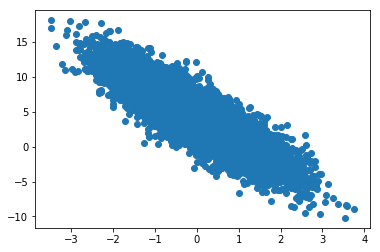

In [7]:
import matplotlib.pyplot as plt
plt.scatter(X[:, 1].asnumpy(), y.asnumpy())
plt.show()

## [Data iterators](http://gluon.mxnet.io/chapter02_supervised-learning/linear-regression-scratch.html#Data-iterators)

Once we start working with neural networks, we’re going to need to iterate through our data points quickly.  
We’ll also want to be able to grab batches of `k` data points at a time, to shuffle our data.  
In MXNet, data iterators give us a nice set of utilities for fetching and manipulating data.  
In particular, we’ll work with the simple `DataLoader` class, that provides an intuitive way to use an `ArrayDataset` for training models.  
We can load `X` and `y` into an ArrayDataset, by calling `gluon.data.ArrayDataset(X, y)`.  
It’s ok for `X` to be a multi-dimensional input array (say, of images) and `y` to be just a one-dimensional array of labels.  
The one requirement is that they have equal lengths along the first axis, i.e., `len(X) == len(y)`.  

Given an `ArrayDataset`, we can create a `DataLoader` which will grab random batches of data from an `ArrayDataset`.  
We’ll want to specify two arguments.  
First, we’ll need to say the `batch_size`, i.e., how many examples we want to grab at a time.  
Second, we’ll want to specify whether or not to shuffle the data between iterations through the dataset.

In [8]:
batch_size = 4
train_data = gluon.data.DataLoader(gluon.data.ArrayDataset(X, y),
                                  batch_size=batch_size, shuffle=True)

Once we’ve initialized our DataLoader (`train_data`), we can easily fetch batches by iterating over `train_data` just as if it were a Python list.  
You can use for favorite iterating techniques like for-each loops:  
`for data, label in train_data`  
or enumerations:  
`for i, (data, label) in enumerate(train_data)`.  
First, let’s just grab one batch and break out of the loop.

In [9]:
for i, (data, label) in enumerate(train_data):
    print(data, label)
    break


[[-0.84728086 -0.9355315 ]
 [-0.22297402 -1.2014743 ]
 [-1.2442706   1.3878686 ]
 [-0.5076725   0.13330546]]
<NDArray 4x2 @cpu(0)> 
[ 5.495935   7.9666047 -3.06012    2.8077338]
<NDArray 4 @cpu(0)>


If we run that same code again, you'll notice that we get a different batch.  
That's because we instructed the `DataLoader` that `shuffle=True`.

In [10]:
for i, (data, label) in enumerate(train_data):
    print(data, label)
    break


[[-1.1884228  -0.5043724 ]
 [-0.32217616 -0.7766785 ]
 [ 0.9110719   0.65439904]
 [ 0.286487   -0.4876767 ]]
<NDArray 4x2 @cpu(0)> 
[3.4965377 6.089349  3.9169474 6.382156 ]
<NDArray 4 @cpu(0)>


Finally, if we actually pass over the entire dataset and count the number of batches we'll find that there are 2500 batches.  
We expect this because our dataset has 10,000 examples and we have configured the `DataLoader` to have a batch size of 4.

In [11]:
counter = 0
for i, (data, label) in enumerate(train_data):
    pass
print(i+1)

2500


## Model parameters